## Example 3 - Plot PDF for a station
This example requires that we have the PDF values already calculated for the target for the requested
days, and those values should live in the database.  If you have not already, you can run this command
to have the values generated for the target-days in this example:

    ./run_ispaq.py -M pdf -S ANMO --starttime 2020-10-01 --endtime 2020-10-26 --output db --pdf_interval aggregated

To generate PDFs, corrected PSD values must already exist. If they do not yet exist, then you can run them via:

    ./run_ispaq.py -M psd_corrected -S ANMO --starttime 2020-10-01 --endtime 2020-10-26 --output db

Or to calculate both PSDs and PDFs at the same time:

    ./run_ispaq.py -M psd_corrected,pdf -S ANMO --starttime 2020-10-01 --endtime 2020-10-26 --output db --pdf_interval aggregated

This example will assume that the above command has already been run and the PDFs already exist.

To begin, we need to import the necessary modules:

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import datetime

Because PDFs are calculated for set frequency bins, which depend on the sample rate of the data, we create a simple function that will help us with placing our tick marks in the right location in the plot.

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

And now set some variables.

In [5]:
db_name = '../ispaq.db'
metric = 'pdf'
startDate = '2020-10-01T00:00:00.000000Z'       # Full time is important for retrieving PDFs
endDate = '2020-10-25T23:59:59.000000Z'
target = 'IU.ANMO.00.BH1'       # the pdf metric does not include a quality code

startdate = startDate.split('T')[0]
enddate = endDate.split('T')[0]
filename = f'example3_{target}_{startdate}_{enddate}_PDF.png'

The first step is to create a query that will be used to retrieve the PDFs.

In [6]:
SQLcommand = f"SELECT * FROM {metric} WHERE start = '{startDate}' " \
             f"and end = '{endDate}' and (target like '{target}');"
print(SQLcommand)

SELECT * FROM pdf WHERE start = '2020-10-01T00:00:00.000000Z' and end = '2020-10-25T23:59:59.000000Z' and (target like 'IU.ANMO.00.BH1');


Create a connection to the database and run the query, loading it into a pandas dataframe

In [7]:
try:
    conn = sqlite3.connect(db_name)
    DF = pd.read_sql_query(SQLcommand, conn, parse_dates=['start','end'])
    conn.close
except:
    print(f"Unable to connect to or find the {metric} table in the database {db_name}")

In [8]:
if DF.empty:
    print("Empty return: there are no PDFs that were retrieved")

In [9]:
print(DF)

              target  frequency  power   hits                     start  \
0     IU.ANMO.00.BH1   0.005256 -186.0    1.0 2020-10-01 00:00:00+00:00   
1     IU.ANMO.00.BH1   0.005256 -184.0    8.0 2020-10-01 00:00:00+00:00   
2     IU.ANMO.00.BH1   0.005256 -183.0   23.0 2020-10-01 00:00:00+00:00   
3     IU.ANMO.00.BH1   0.005256 -182.0   63.0 2020-10-01 00:00:00+00:00   
4     IU.ANMO.00.BH1   0.005256 -181.0  127.0 2020-10-01 00:00:00+00:00   
...              ...        ...    ...    ...                       ...   
3109  IU.ANMO.00.BH1  19.740300  -75.0   12.0 2020-10-01 00:00:00+00:00   
3110  IU.ANMO.00.BH1  19.740300  -74.0   20.0 2020-10-01 00:00:00+00:00   
3111  IU.ANMO.00.BH1  19.740300  -73.0   10.0 2020-10-01 00:00:00+00:00   
3112  IU.ANMO.00.BH1  19.740300  -72.0    1.0 2020-10-01 00:00:00+00:00   
3113  IU.ANMO.00.BH1  19.740300  -70.0    1.0 2020-10-01 00:00:00+00:00   

                           end               lddate  
0    2020-10-25 23:59:59+00:00  2021-03-03 19

Sum up the total number of hits for each frequency:

In [10]:
for frequency in DF['frequency'].unique():
        # Sum hits for total column
        DF.loc[DF['frequency'] == frequency, 'total'] = sum(DF[DF['frequency'] == frequency]['hits'])

For each frequency-power bin, calculate what percentage of the total hits for that frequency are at that power. 

In [11]:
DF['percent'] = DF['hits'] / DF['total'] * 100

Create a minimum range of powers (Y-axis) for better viewing.

In [12]:
p1 = int(min(DF['power'].unique()))
p2 = int(max(DF['power'].unique()))
if p1 > -190:
    p1 = -190
if p2 < -90:
    p2 = -90
    
powers = sorted(range(p1,p2+1), reverse=True)
freqs = sorted(DF['frequency'].unique(),reverse = True)

Create a new dataframe for plotting: rows are powers, columns are periods, value is percent of hits

In [13]:
plotDF = pd.DataFrame(0,index=powers,columns=freqs)
nonZeroFreqs=[]
for power in powers:
    for freq in freqs:
        value = DF[(DF['frequency']==freq) & (DF['power']== power)]['percent'].values
        try:
            plotDF.loc[power,freq] = value[0]
            if value[0] != 0:
                # Keep track of the frequencies that have hits, for axes limits
                nonZeroFreqs.append(freq)
        except:
            continue

Matplotlib imshow takes a list (matrix) of values, so convert the dataframe to a list

In [14]:
plotList = plotDF.values.tolist()

And now we set up some plotting options:

In [15]:
# Set up plotting -- color map
cmap = plt.get_cmap('gist_heat', 3000)  # You can change the colormap here
cmaplist = [cmap(i) for i in range(cmap.N)]

# convert the first nchange to fade from white, so that anywhere without any hits (or very few) is white
nchange = 100
for i in range(nchange):
    first = cmaplist[nchange][0]
    second = cmaplist[nchange][1]
    third = cmaplist[nchange][2]
    scaleFactor = (nchange-1-i)/float(nchange)

    df = ((1-first) * scaleFactor) + first
    ds = ((1-second)* scaleFactor) + second
    dt = ((1-third) * scaleFactor) + third

    cmaplist[i] = (df, ds, dt, 1)

cmaplist[0] = (1,1,1,1)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

In [16]:
# Set up plotting -- axis labeling and ticks
periodPoints = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
freqPoints = [1/float(i) for i in periodPoints]
xfilter = [(i <= freqs[0]) and (i >= freqs[-1]) for i in freqPoints]
xlabels = [i for (i, v) in zip(freqPoints, xfilter) if v]
xticks = [find_nearest(freqs, i) for i in xlabels]
xlabels = [int(1/i)  if i<=1 else 1/i for i in xlabels]     #convert to period, use decimal only if <1s

yticks = [powers.index(i) for i in list(filter(lambda x: (x % 10 == 0), powers))]
ylabels = [powers[i] for i in yticks]

In [17]:
# Set up plotting -- plot
height = ylabels[0] - ylabels[-1]
plt.figure(figsize=( 12, (.055*height + .5) ))

<Figure size 864x511.2 with 0 Axes>

<Figure size 864x511.2 with 0 Axes>

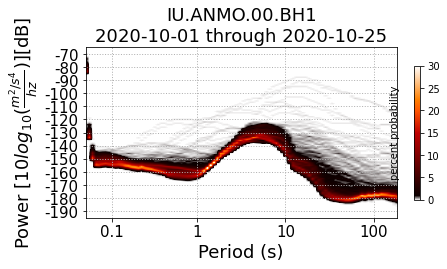

In [18]:
plt.imshow(plotList, cmap=cmap,  vmin=0, vmax=30, aspect=.4, interpolation='bilinear')
# Adjust grids, labels, limits, titles, etc
plt.grid(linestyle=':', linewidth=1)
plt.xlabel('Period (s)',size=18)
plt.ylabel(r'Power [$10log_{10}(\frac{m^2/s^4}{hz}$)][dB]',size=18)

plt.xticks(xticks[::-1], xlabels[::-1],size=15)
plt.yticks(yticks,ylabels,size=15)

xmin=freqs.index(min(nonZeroFreqs))
xmax=freqs.index(max(nonZeroFreqs))
plt.xlim(xmax,xmin)
plt.ylim(max(yticks)+5,min(yticks)-5)

plt.title(f"{target}\n{startdate} through {enddate}", size=18)

# User has option to include colorbar and/or legend
cb = plt.colorbar(fraction=.02)
cb.set_label('percent probability',labelpad=-50)


Save the figure for later use:

In [ ]:
plt.tight_layout()
plt.savefig(filename)